# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Checkpoint" data-toc-modified-id="Checkpoint-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Checkpoint</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#Set-Hyperparameters" data-toc-modified-id="Set-Hyperparameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set Hyperparameters</a></div><div class="lev1 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev1 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev1 toc-item"><a href="#Train" data-toc-modified-id="Train-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train</a></div>

# Checkpoint

In [1]:
import h5py
import pickle

In [2]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/CausalNet/index.pkl', 'rb') as fp:
    word2index, index2word = pickle.load(fp)

In [3]:
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/CausalNet/word2vec/train.h5', 'r') as fh:
    xTrain = fh['xTrain'][:]
    yTrain = fh['yTrain'][:]

# Import Libraries

In [8]:
from keras.layers import Input, Embedding, Dense, Flatten, BatchNormalization, Activation
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from tqdm import tqdm
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


# Set Hyperparameters

In [66]:
VOCAB_SIZE = len(word2index)+1
EMBEDDING_DIM = 256
BATCH_SIZE = 1024
NUM_EPOCHS = 256
STEPS_PER_EPOCH = 2048

# Build Graph

In [72]:
def build():
    """
    Build embedding matrix
    """
    K.clear_session()
    seq = Input(shape=(None,), dtype='int64')
    emb = Embedding(VOCAB_SIZE,
                    EMBEDDING_DIM,
                    mask_zero=False,
                    trainable=True)(seq)
    model = Model(inputs=seq, outputs=emb)
    return model

In [73]:
K.clear_session()

embedding = build()

inputs = Input(shape=(1,), name='INPUT', dtype='int64')
embSeq = embedding(inputs)
embSeq = Flatten(name='FLATTEN')(embSeq)
dense = Dense(VOCAB_SIZE, activation=None, name='DENSE')(embSeq)
bn = BatchNormalization(name='BN')(dense)
out = Activation('softmax', name='OUTPUT')(bn)
model = Model(inputs=inputs, outputs=out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

# Model Visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         715520    
Total params: 715,520
Trainable params: 715,520
Non-trainable params: 0
_________________________________________________________________


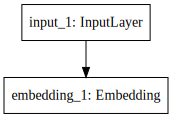

In [74]:
embedding.summary()
SVG(model_to_dot(embedding).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 1)                 0         
_________________________________________________________________
model_1 (Model)              multiple                  715520    
_________________________________________________________________
FLATTEN (Flatten)            (None, 256)               0         
_________________________________________________________________
DENSE (Dense)                (None, 2795)              718315    
_________________________________________________________________
BN (BatchNormalization)      (None, 2795)              11180     
_________________________________________________________________
OUTPUT (Activation)          (None, 2795)              0         
Total params: 1,445,015
Trainable params: 1,439,425
Non-trainable params: 5,590
______________________________________________________________

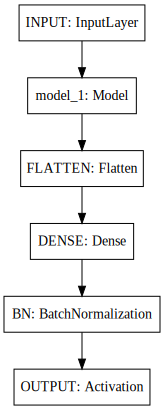

In [75]:
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Train

In [76]:
filepath = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/CausalNet/word2vec/cp_logs/weights.{epoch:03d}-{loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
log_string = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/CausalNet/word2vec/tb_logs/1'
tensorboard = TensorBoard(log_dir=log_string)
callbacks_list = [checkpoint, tensorboard]

In [77]:
def data_generator(data, label, batch_size):
    """
    Yield batches of all data
    """
    count = 0
    while True:
        if count >= len(data): 
            count = 0
        x = np.zeros((batch_size, 1))
        y = np.zeros((batch_size, 1))
        for i in range(batch_size):
            n = i + count
            if n > len(data)-1:
                break
            x[i, :] = data[n]
            y[i, :] = label[n]
        count += batch_size
        yield (x, y)

In [78]:
gen_train = data_generator(xTrain, yTrain, BATCH_SIZE)

In [ ]:
history = model.fit_generator(gen_train,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=NUM_EPOCHS,
                              callbacks=callbacks_list,
                              workers=4,
                              use_multiprocessing=True)